In [2]:
# from tensorboard.backend.event_processing import event_accumulator
# ea = event_accumulator.EventAccumulator('../runs/Sep12_15-52-32_baldeeb-desktop/events.out.tfevents.1631476352.baldeeb-desktop.149179.0')
# # ea = event_accumulator.EventAccumulator('../runs/Sep11_23-26-10_baldeeb-desktop/events.out.tfevents.1631417170.baldeeb-desktop.74534.0')
# ea.Reload()
# ea.Tags()

In [1]:

# descriptors = ea.Images('descriptor')
# images = ea.Images('image')

# images[-1].encoded_image_string

In [1]:
%cd /home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor

%load_ext autoreload
%autoreload 2

/home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor


In [2]:
#temp config 
class cfg():
    dataset = 'unreal_parts'
    data_dir = '../simple_data'
    image_type = 'RGB'
    obj_class = 'mug'
    n_pair = 0
    n_nonpair_singleobj = 0 
    n_nonpair_bg = 0
    batch_size = 1
    workers = 1

    device = 'cuda:0'
    # device = 'cpu'

In [3]:
import torch 
from torchvision.models.segmentation import deeplabv3_resnet50

## Load model
file = '/home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor/temp/results_old/first_successful_run/model_checkpoints/13_09_2021__11_29_03_19_final'
device = torch.device('cuda:0')
state_dict = torch.load(file, map_location=device)
backbone = deeplabv3_resnet50(num_classes=3).to(device)
backbone.load_state_dict(state_dict['model_state_dict'])

## Load data
from dataset import make_data_loader
dataloader = make_data_loader(split='train', args=cfg())

## Run model
descriptors, images = None, None
for im, batch in dataloader:
    images = im.to(device)
    descriptors = backbone(images)['out']
    break


/home/baldeeb/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


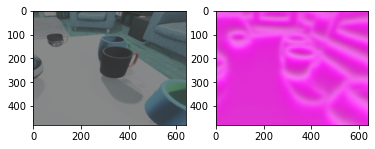

In [4]:
## De-Normalize
data_mean, data_std = [0.5183, 0.5747, 0.7210], [0.3218, 0.3045, 0.2688]  # Unreal Progress Mugs
im = images[0].clone().detach().cpu()
im = im * torch.tensor(data_std).reshape(-1, 1, 1) + torch.tensor(data_mean).reshape(-1, 1, 1)
d = descriptors[0].clone().detach().sigmoid().cpu()

# print(descriptors.min(), descriptors.max(), descriptors.mean(), descriptors.std())

## Visualize
import matplotlib.pyplot as plt
def visualize(image, descriptor):
    fig = plt.figure(); gs = fig.add_gridspec(1, 2); axs = gs.subplots()
    image = image.permute(1,2,0).float()
    descriptor = descriptor.permute(1,2,0).float()
    axs[0].imshow(image)
    axs[1].imshow(descriptor) 
    plt.show()

visualize(im, d)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


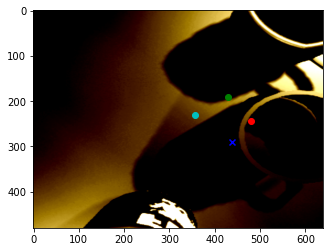

In [33]:
from dataset import sample_from_augmented_pair

images = None
positive_samples, negative_samples = None, None
IMAGE_SHAPE = (480, 640)
mask = torch.zeros(IMAGE_SHAPE)
mask[300:400, 300:400] = 1
for im, batch in dataloader:
    images = im.to(device)
    augmentors = [batch[i]['augmentor'] for i in range(2)]
    # positive_samples, negative_samples = sample_from_augmented_pair(IMAGE_SHAPE, augmentors, ROI_mask=mask)
    positive_samples, negative_samples = sample_from_augmented_pair(IMAGE_SHAPE, augmentors,
                                                            num_samples=2000, neg_sample_mean_dist=[100, 150, 175], 
                                                            neg_sample_sigmas=[10, 30, 50])
    break


fig, ax = plt.subplots()
ax.imshow(images[0].detach().clone().cpu().permute(1,2,0).numpy())
ax.scatter(positive_samples[0][0], positive_samples[1][0], color='b', marker='x')

for n, c in zip(negative_samples, ['g', 'r', 'c']): 
    ax.scatter(n[0][0], n[1][0], color=c)

